# Data Import

In [1]:
# %%capture
# !pip install scikit-learn
# !pip install fancyimpute
# !pip install xgboost
# !pip install graphviz
# !pip install GPyOpt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import graphviz
from fancyimpute import IterativeImputer
import shap
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_importance
from fancyimpute import IterativeImputer
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2_m74w5o because the default path (/gpfs/home/pandik01/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
df = pd.read_csv('/gpfs/data/proteomics/projects/pandik01/cleaned_data_09_08_2021.csv')

In [5]:
#changing cols with mixed dtypes to single dtype 
df.astype({df.columns[10]:'str', df.columns[11]:'str', df.columns[38]:'str'})

df.shape

(31580, 415)

In [6]:
col_names = ['Patient.Age', 'AGE_AT_DELIVERY', 'Gravida', 'Para', 'Term', 'Preterm', 'Abortions', 
             'Living.at.Delivery.Ct', 'RACE_White', 'RACE_African_American', 'RACE_Asian', 
             'RACE_Native_Hawaiian_or_Other_Pacific_Islander', 'RACE_Other_Race', 
             'ETHNICITY_Not_of_Spanish_Hispanic_Origin','ETHNICITY_Patient_Refused', 
             'ETHNICITY_Unknown', 'R.BMI', 'GA_IN_DAYS', 'Insulin', 'Insulin.NPH', 'Insulin.aspart', 'Insulin.detemir',
             'Insulin.glargine','Insulin.lispro','Insulin.regular', 'Oral.glycemic','GLUCOSE.CHALLENGE..PREGNANCY',
             'GLUCOSE.TOLERANCE.TEST.1.HOUR','GLUCOSE.TOLERANCE.TEST.2.HOUR','GLUCOSE.TOLERANCE.TEST.3.HOUR',
            'HEMOGLOBIN_FIRST_TRIMESTER','HEMOGLOBIN_SECOND_TRIMESTER','HEMOGLOBIN_THIRD_TRIMESTER',
             'PMH_Macrosomia_or_LGA', 'Macrosomia','IUGR','IUFD_or_demise','Grand_multip','Apgar.1','Apgar.5',
             'Apgar.10','Baby.Sex']
df = df[col_names]
        

In [7]:
#remaining features with NaN values
df.columns[df.isna().sum()!=0]

Index(['Patient.Age', 'AGE_AT_DELIVERY', 'Gravida', 'Para', 'Term', 'Preterm',
       'Abortions', 'Living.at.Delivery.Ct', 'R.BMI', 'GA_IN_DAYS',
       'GLUCOSE.CHALLENGE..PREGNANCY', 'GLUCOSE.TOLERANCE.TEST.1.HOUR',
       'GLUCOSE.TOLERANCE.TEST.2.HOUR', 'GLUCOSE.TOLERANCE.TEST.3.HOUR',
       'HEMOGLOBIN_FIRST_TRIMESTER', 'HEMOGLOBIN_SECOND_TRIMESTER',
       'HEMOGLOBIN_THIRD_TRIMESTER', 'Apgar.1', 'Apgar.5', 'Apgar.10',
       'Baby.Sex'],
      dtype='object')

In [8]:
#combining 'Patient.Age' and 'AGE_AT_DELIVERY' columns to fill NaN

#converting dtype to int for both columns
df['Patient.Age'] = df['Patient.Age'].fillna(0).astype(int)
df['AGE_AT_DELIVERY'] = df['AGE_AT_DELIVERY'].fillna(0).astype(int)

#replacing NaN values in 'Patient.Age' using 'AGE_AT_DELIVERY' values
df.iloc[:,:1] = df['AGE_AT_DELIVERY'].combine_first(df['Patient.Age'])

#dropping one of two age descriptors
df = df.drop(columns = 'Patient.Age') #redundant

#confirming no NaN values in Patient.Age
df[df['AGE_AT_DELIVERY'].isnull()]

,AGE_AT_DELIVERY,Gravida,Para,Term,Preterm,Abortions,Living.at.Delivery.Ct,RACE_White,RACE_African_American,RACE_Asian,...,HEMOGLOBIN_THIRD_TRIMESTER,PMH_Macrosomia_or_LGA,Macrosomia,IUGR,IUFD_or_demise,Grand_multip,Apgar.1,Apgar.5,Apgar.10,Baby.Sex


In [9]:
## remaining features with NaN values
# df.isna().sum()

In [10]:
#dropping all columns where most entries are NaN (>50%)
df = df.dropna(axis=1, thresh = 15000)

#remaining features with NaN values
df.shape

(31580, 34)

# Data Preprocessing

In [11]:
#converting all missing values to zeroes
df = df.fillna(0)

#replacing spaces in df with underscores
df.replace(' ', '_', regex=True, inplace=True)

#replacing spaces and periods in column names with underscores (necessary for plotting tree later on)
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('.', '_')

df.head()

,AGE_AT_DELIVERY,Gravida,Para,Term,Preterm,Abortions,Living_at_Delivery_Ct,RACE_White,RACE_African_American,RACE_Asian,...,Oral_glycemic,HEMOGLOBIN_THIRD_TRIMESTER,PMH_Macrosomia_or_LGA,Macrosomia,IUGR,IUFD_or_demise,Grand_multip,Apgar_1,Apgar_5,Baby_Sex
0,36,3.0,1.0,1.0,0.0,0.0,0.0,1,0,0,...,0,14.1,0,0,0,0,0,7.0,9.0,1.0
1,36,3.0,1.0,1.0,0.0,0.0,0.0,1,0,0,...,0,14.1,0,0,0,0,0,9.0,9.0,1.0
2,30,3.0,1.0,1.0,0.0,1.0,1.0,1,0,0,...,0,12.4,0,0,0,0,0,8.0,9.0,1.0
3,31,4.0,3.0,3.0,0.0,0.0,2.0,1,0,0,...,0,13.7,0,0,0,0,0,9.0,9.0,0.0
4,40,4.0,2.0,2.0,0.0,1.0,0.0,0,0,1,...,0,12.8,0,0,0,0,0,9.0,9.0,0.0


# Splitting Data

In [12]:
#creating featuers variable by removing Macrosomia column
X = df.drop('Macrosomia', axis = 1).copy()

#creating labels variable using Macrosomia column
y = pd.DataFrame(df['Macrosomia'])

In [13]:
#splitting data into train/validation/test (60/20/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle = True, stratify = y_train)

In [14]:
X_train.shape

(18948, 33)

In [15]:
X_valid.shape

(6316, 33)

In [16]:
X_test.shape

(6316, 33)

In [17]:
#verifying class balance is maintained across datasets as bar graph

def plot_counts(df, title):
    Normal, Macrosomia = df['Macrosomia'].value_counts()
    plt.figure(figsize=(4,4))
    sns.countplot('Macrosomia', data=df, palette="Paired")
    plt.title(title)
    plt.annotate(Normal, xy=(-0.2, 250), xytext=(-0.1, 280), size=12, color='black')
    plt.annotate(Macrosomia, xy=(-0.2, 250), xytext=(0.9, 280), size=12, color='black')
    plt.show()

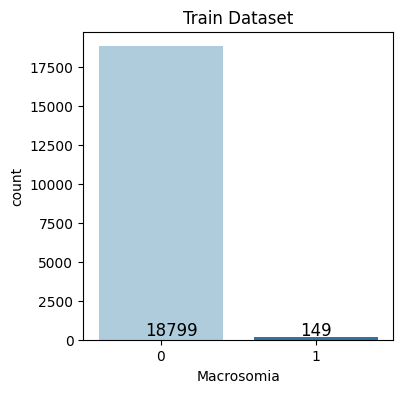

In [18]:
plot_counts(y_train, 'Train Dataset')

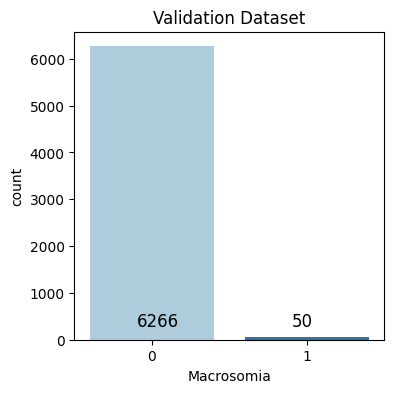

In [19]:
plot_counts(y_valid, 'Validation Dataset')

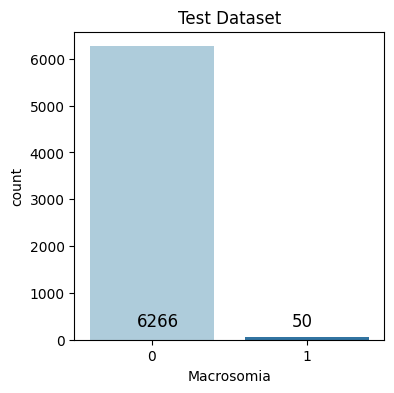

In [20]:
plot_counts(y_test, 'Test Dataset')

# Model Building

## Scenario 13:

### Imputation method: XGB Missing parameter (XGB MP)
### Class imbalance: Yes (CI)
### Feature selection: No (No FS)
### Optimization: Grid search (GS)

In [21]:
#fitting model to train set
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, scale_pos_weight = 126, missing = 0)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric=['aucpr', 'error'],
           eval_set=[(X_train, y_train), (X_valid, y_valid)])

[0]	validation_0-aucpr:0.06648	validation_0-error:0.35761	validation_1-aucpr:0.07255	validation_1-error:0.36906
[1]	validation_0-aucpr:0.07018	validation_0-error:0.29380	validation_1-aucpr:0.03750	validation_1-error:0.30130
[2]	validation_0-aucpr:0.09492	validation_0-error:0.26282	validation_1-aucpr:0.05453	validation_1-error:0.27011
[3]	validation_0-aucpr:0.10391	validation_0-error:0.18947	validation_1-aucpr:0.05181	validation_1-error:0.19569
[4]	validation_0-aucpr:0.11246	validation_0-error:0.16535	validation_1-aucpr:0.05554	validation_1-error:0.17416
[5]	validation_0-aucpr:0.12148	validation_0-error:0.16002	validation_1-aucpr:0.05278	validation_1-error:0.17052
[6]	validation_0-aucpr:0.14461	validation_0-error:0.15157	validation_1-aucpr:0.05628	validation_1-error:0.16039
[7]	validation_0-aucpr:0.16175	validation_0-error:0.14387	validation_1-aucpr:0.05388	validation_1-error:0.15152
[8]	validation_0-aucpr:0.17283	validation_0-error:0.14265	validation_1-aucpr:0.07723	validation_1-error:

[73]	validation_0-aucpr:0.98941	validation_0-error:0.01203	validation_1-aucpr:0.04641	validation_1-error:0.02581
[74]	validation_0-aucpr:0.98963	validation_0-error:0.01193	validation_1-aucpr:0.04591	validation_1-error:0.02533
[75]	validation_0-aucpr:0.98950	validation_0-error:0.01182	validation_1-aucpr:0.04558	validation_1-error:0.02533
[76]	validation_0-aucpr:0.99034	validation_0-error:0.01156	validation_1-aucpr:0.04546	validation_1-error:0.02517
[77]	validation_0-aucpr:0.99049	validation_0-error:0.01140	validation_1-aucpr:0.05759	validation_1-error:0.02502
[78]	validation_0-aucpr:0.99078	validation_0-error:0.01108	validation_1-aucpr:0.05767	validation_1-error:0.02470
[79]	validation_0-aucpr:0.99122	validation_0-error:0.01082	validation_1-aucpr:0.04320	validation_1-error:0.02470
[80]	validation_0-aucpr:0.99111	validation_0-error:0.01082	validation_1-aucpr:0.04352	validation_1-error:0.02280
[81]	validation_0-aucpr:0.99198	validation_0-error:0.01019	validation_1-aucpr:0.04362	validation

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=0, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

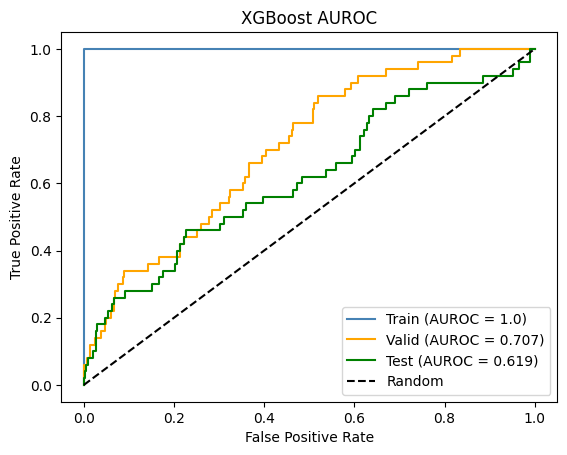

In [22]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

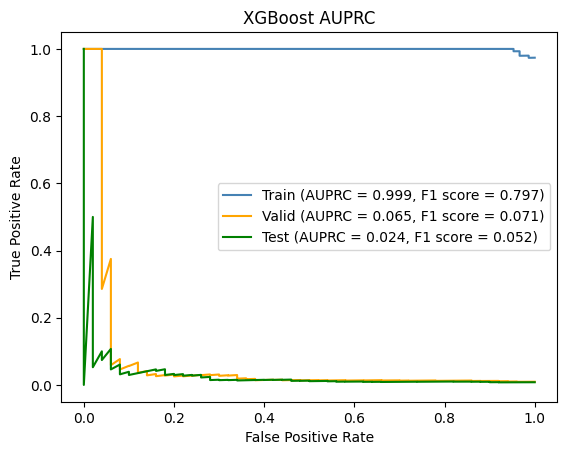

In [23]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

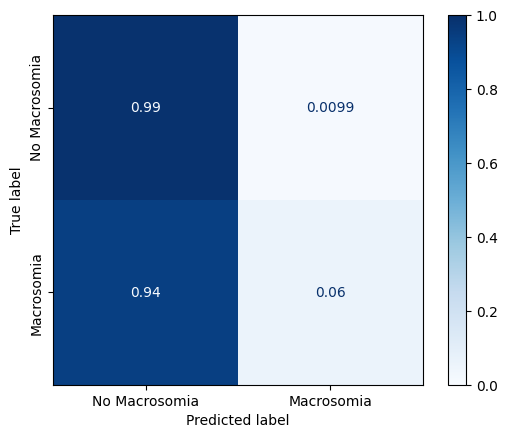

In [24]:
#plotting confusion matrix
predictions = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        clf_xgb,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

In [25]:
# #optimizating using Grid Search

# #ROUND 1

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.5, 1],
#     'reg_lambda': [0, 5, 10], 
#     'n_estimators': [50, 70, 90],
#     'min_child_weight': [5, 6, 7]
# }

In [31]:
# #ROUND 2

# param_grid = {
#     'max_depth': [5, 6, 7],
#     'learning_rate': [0.1, 0.2, 0.3],
#     'gamma': [0],
#     'reg_lambda': [5],
#     'n_estimators': [30, 40, 50],
#     'min_child_weight': [3, 4, 5]
# }

In [36]:
#ROUND 3

param_grid = {
    'max_depth': [5],
    'learning_rate': [0.1],
    'gamma': [0],
    'reg_lambda': [5],
    'n_estimators': [10, 20, 30],
    'min_child_weight': [5]
}

In [38]:
#grid searching for best hyperparameters
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5,
                                scale_pos_weight = 126,
                                missing = 0),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs = 10,
    cv = 5
)

In [39]:
#printing optimal parameters to readjust for actual training
optimal_params.fit(X_train, 
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(X_valid, y_valid)],
                  verbose=True)
print(optimal_params.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[0]	validation_0-auc:0.68018
[1]	validation_0-auc:0.75401
[2]	validation_0-auc:0.72564
[3]	validation_0-auc:0.74293
[4]	validation_0-auc:0.74992
[5]	validation_0-auc:0.75390
[6]	validation_0-auc:0.75038
[7]	validation_0-auc:0.76610
[8]	validation_0-auc:0.76925
[9]	validation_0-auc:0.76791
[10]	validation_0-auc:0.76537
[11]	validation_0-auc:0.75855
[12]	validation_0-auc:0.75583
[13]	validation_0-auc:0.75726
[14]	validation_0-auc:0.75931
[15]	validation_0-auc:0.76072
[16]	validation_0-auc:0.75986
[17]	validation_0-auc:0.76473
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 20, 'reg_lambda': 5}


In [40]:
#fitting model to tuned hyperparameters
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42,
                            gamma=0,
                            learning_rate=0.1,
                            max_depth=5,
                            min_child_weight = 5,
                            n_estimators = 20,
                            reg_lambda=5,
                            scale_pos_weight=126, #sum(negative instances) / sum(positive instances)
                            subsample=0.9,
                            colsample_bytree=0.5,
                            missing = 0)

clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='auc',
           eval_set=[(X_train, y_train), (X_valid, y_valid), (X_test, y_test)])

[0]	validation_0-auc:0.78607	validation_1-auc:0.68018	validation_2-auc:0.65314
[1]	validation_0-auc:0.86276	validation_1-auc:0.75401	validation_2-auc:0.71249
[2]	validation_0-auc:0.88729	validation_1-auc:0.72564	validation_2-auc:0.70704
[3]	validation_0-auc:0.90909	validation_1-auc:0.74293	validation_2-auc:0.71926
[4]	validation_0-auc:0.91417	validation_1-auc:0.74992	validation_2-auc:0.71479
[5]	validation_0-auc:0.91628	validation_1-auc:0.75390	validation_2-auc:0.71594
[6]	validation_0-auc:0.91794	validation_1-auc:0.75038	validation_2-auc:0.71835
[7]	validation_0-auc:0.92263	validation_1-auc:0.76610	validation_2-auc:0.72607
[8]	validation_0-auc:0.92754	validation_1-auc:0.76925	validation_2-auc:0.72668
[9]	validation_0-auc:0.93331	validation_1-auc:0.76791	validation_2-auc:0.72833
[10]	validation_0-auc:0.93631	validation_1-auc:0.76537	validation_2-auc:0.72820
[11]	validation_0-auc:0.93784	validation_1-auc:0.75855	validation_2-auc:0.72175
[12]	validation_0-auc:0.93862	validation_1-auc:0.7

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
              missing=0, monotone_constraints='()', n_estimators=20, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=5, ...)

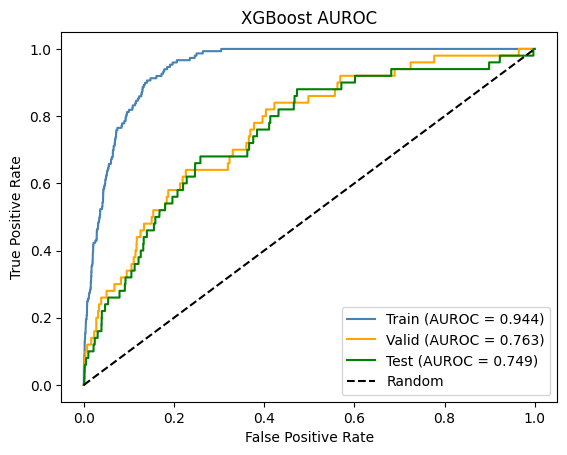

In [47]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

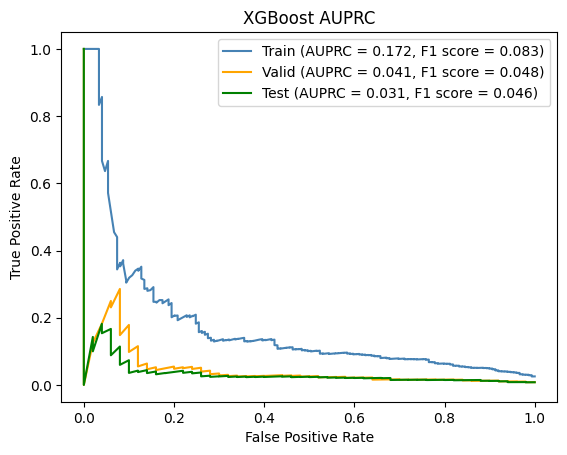

In [48]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

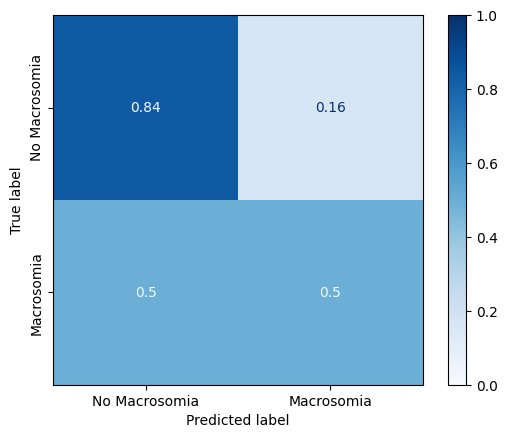

In [49]:
#plotting confusion matrix
predictions = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        clf_xgb,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

weight:  {'AGE_AT_DELIVERY': 57.0, 'Gravida': 14.0, 'Para': 22.0, 'Term': 11.0, 'Preterm': 5.0, 'Abortions': 13.0, 'Living_at_Delivery_Ct': 13.0, 'RACE_White': 15.0, 'RACE_African_American': 2.0, 'RACE_Asian': 1.0, 'RACE_Native_Hawaiian_or_Other_Pacific_Islander': 1.0, 'RACE_Other_Race': 6.0, 'ETHNICITY_Patient_Refused': 3.0, 'R_BMI': 81.0, 'GA_IN_DAYS': 49.0, 'Insulin': 4.0, 'Insulin_aspart': 1.0, 'Insulin_lispro': 2.0, 'HEMOGLOBIN_THIRD_TRIMESTER': 35.0, 'PMH_Macrosomia_or_LGA': 8.0, 'IUGR': 4.0, 'IUFD_or_demise': 1.0, 'Apgar_1': 18.0, 'Apgar_5': 10.0, 'Baby_Sex': 1.0}
gain:  {'AGE_AT_DELIVERY': 272.338623046875, 'Gravida': 199.70066833496094, 'Para': 467.7855529785156, 'Term': 452.62615966796875, 'Preterm': 197.11239624023438, 'Abortions': 181.12010192871094, 'Living_at_Delivery_Ct': 281.9295349121094, 'RACE_White': 223.049072265625, 'RACE_African_American': 175.32211303710938, 'RACE_Asian': 392.26239013671875, 'RACE_Native_Hawaiian_or_Other_Pacific_Islander': 40.08218002319336, 'RA

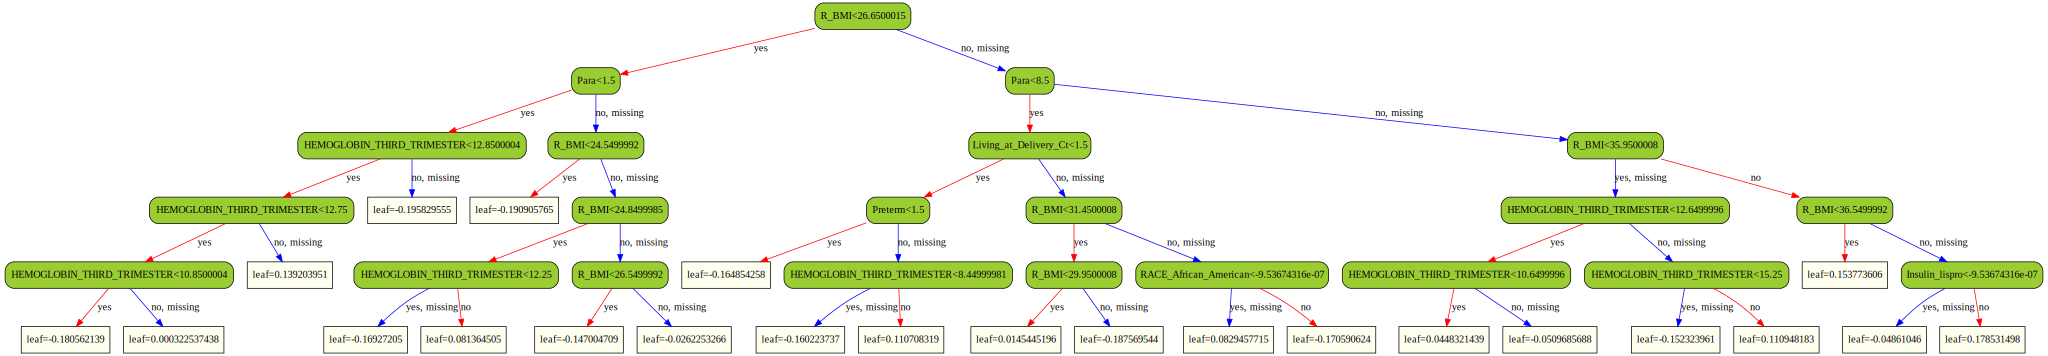

In [50]:
#plotting tree
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(clf_xgb, num_trees=1
                , size='10,10',
               condition_node_params=node_params,
               leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

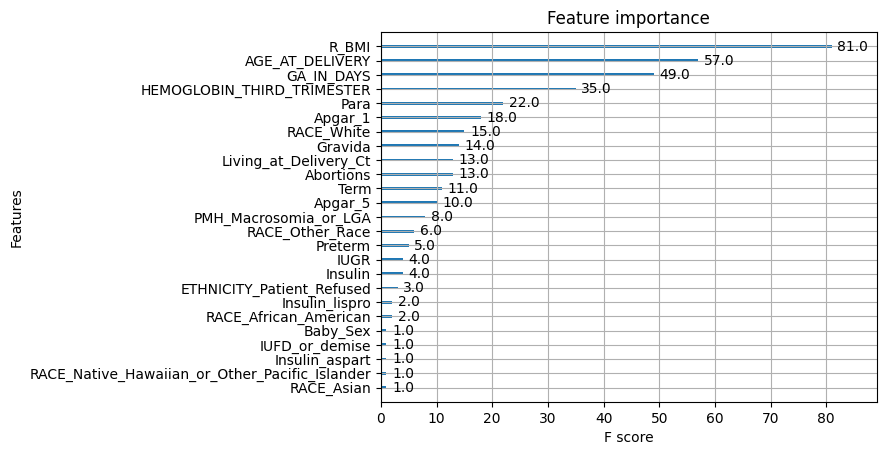

In [51]:
#plotting overall feature importance
plot_importance(clf_xgb)
plt.show()

In [52]:
#plotting individual feature importance
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])

## Scenario 14:

### Imputation method: XGB Missing parameter (XGB MP)
### Class imbalance: Yes (CI)
### Feature selection: No (No FS)
### Optimization: Bayesian (Bay.)

In [53]:
#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators, learning_rate, reg_lambda, min_child_weight):
    params = {'max_depth': int(max_depth),
              'learning_rate':learning_rate,
              'gamma': gamma,
              'reg_lambda': reg_lambda,
              'n_estimators': int(n_estimators),
              'min_child_weight': min_child_weight,
              'subsample': 0.9,
              'eta': 0.1,
              
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'learning_rate': (0, 1),
                                            'gamma': (0, 5),
                                            'reg_lambda': (3, 20), 
                                            'n_estimators': (50, 350),
                                            'min_child_weight': (1, 10)
                                            }, random_state = 42)

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
[08:26:14] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:26:14] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:26:14] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } mig

|  5        | -0.08746  |  2.28     |  0.7852   |  4.398    |  5.628    |  227.7    |  3.79     |
[08:27:13] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:27:13] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:27:13] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

[08:27:54] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:27:55] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


|  10       | -0.08702  |  0.621    |  0.7127   |  8.185    |  2.408    |  240.1    |  18.04    |
[08:28:10] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
bay_classifier = XGBClassifier(**params).fit(X_train, y_train)

#predicting for training set
train_p2 = bay_classifier.predict(X_valid)

#Looking at the classification report
print(classification_report(train_p2, y_valid))

{'gamma': 0.6210253030076818, 'learning_rate': 0.7127163200122792, 'max_depth': 8.184814766639303, 'min_child_weight': 2.4077385795083055, 'n_estimators': 240.14563085673808, 'reg_lambda': 18.04311435327639}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6316
           1       0.00      0.00      0.00         0

    accuracy                           0.99      6316
   macro avg       0.50      0.50      0.50      6316
weighted avg       1.00      0.99      1.00      6316



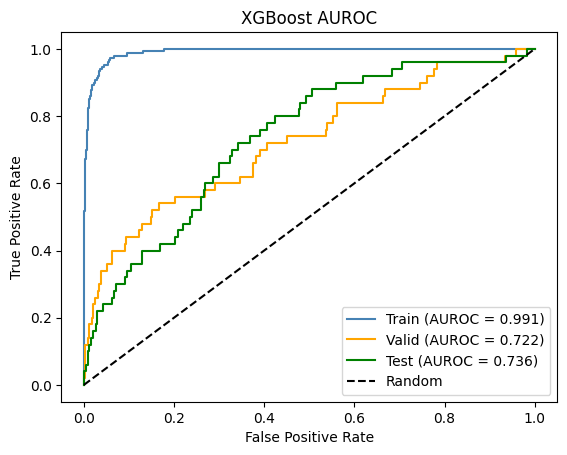

In [55]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = bay_classifier.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

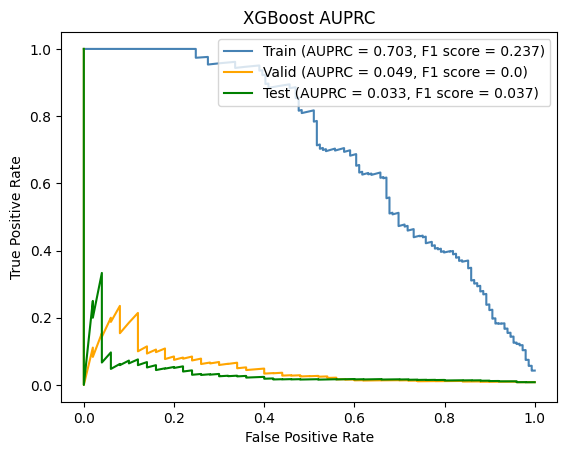

In [56]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()
y_pred = bay_classifier.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

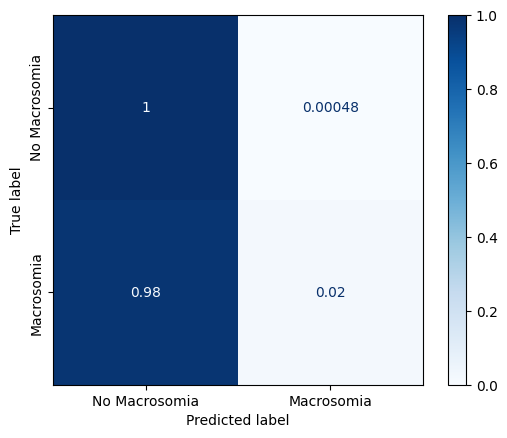

In [57]:
#plotting confusion matrix
predictions = bay_classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=bay_classifier.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        bay_classifier,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

weight:  {'AGE_AT_DELIVERY': 91.0, 'Gravida': 38.0, 'Para': 21.0, 'Term': 12.0, 'Preterm': 4.0, 'Abortions': 17.0, 'Living_at_Delivery_Ct': 22.0, 'RACE_White': 18.0, 'RACE_African_American': 3.0, 'RACE_Asian': 6.0, 'RACE_Other_Race': 7.0, 'ETHNICITY_Not_of_Spanish_Hispanic_Origin': 2.0, 'R_BMI': 179.0, 'GA_IN_DAYS': 141.0, 'Insulin': 7.0, 'HEMOGLOBIN_THIRD_TRIMESTER': 152.0, 'PMH_Macrosomia_or_LGA': 4.0, 'IUGR': 4.0, 'IUFD_or_demise': 1.0, 'Apgar_1': 35.0, 'Apgar_5': 12.0, 'Baby_Sex': 16.0}
gain:  {'AGE_AT_DELIVERY': 0.9855244159698486, 'Gravida': 0.779742419719696, 'Para': 1.2286760807037354, 'Term': 1.8952950239181519, 'Preterm': 0.9878185987472534, 'Abortions': 0.7951045036315918, 'Living_at_Delivery_Ct': 1.0721455812454224, 'RACE_White': 1.1610044240951538, 'RACE_African_American': 0.7389373183250427, 'RACE_Asian': 0.8035357594490051, 'RACE_Other_Race': 0.5442363023757935, 'ETHNICITY_Not_of_Spanish_Hispanic_Origin': 0.5883380174636841, 'R_BMI': 0.9563046097755432, 'GA_IN_DAYS': 0.8

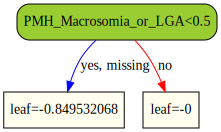

In [58]:
#plotting tree
bst = bay_classifier.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(bay_classifier, num_trees=1, 
                size='10,10',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

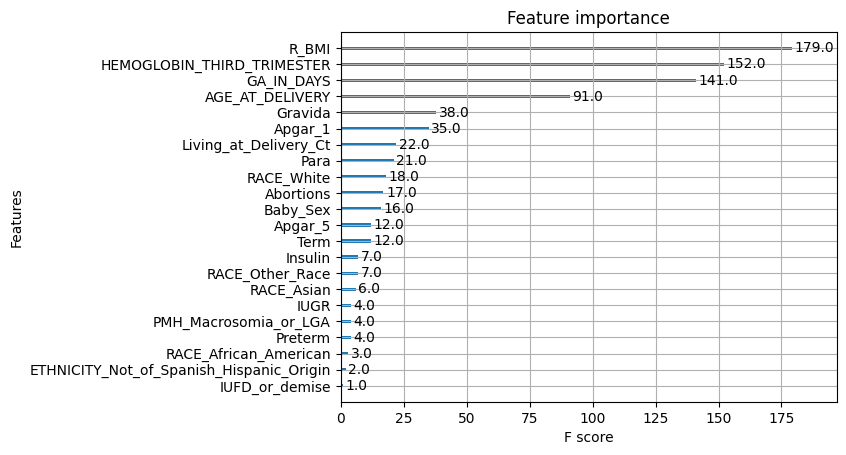

In [59]:
#plotting overall feature importance
plot_importance(bay_classifier)
plt.show()

In [60]:
#plotting individual feature importance
explainer = shap.Explainer(bay_classifier)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])

## Scenario 15:

### Imputation method: XGB Missing parameter (XGB MP)
### Class imbalance: Yes (CI)
### Feature selection: Yes (FS)
### Optimization: Grid search (GS)

In [61]:
#selecting features

thresholds = sort(clf_xgb.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(clf_xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier(scale_pos_weight = 126, missing = 0)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=33, Accuracy: 98.27%
Thresh=0.000, n=33, Accuracy: 98.27%
Thresh=0.000, n=33, Accuracy: 98.27%
Thresh=0.000, n=33, Accuracy: 98.27%
Thresh=0.000, n=33, Accuracy: 98.27%
Thresh=0.000, n=33, Accuracy: 98.27%
Thresh=0.000, n=33, Accuracy: 98.27%
Thresh=0.000, n=33, Accuracy: 98.27%
Thresh=0.007, n=25, Accuracy: 98.45%
Thresh=0.012, n=24, Accuracy: 98.59%
Thresh=0.019, n=23, Accuracy: 98.59%
Thresh=0.022, n=22, Accuracy: 98.18%
Thresh=0.023, n=21, Accuracy: 98.39%
Thresh=0.024, n=20, Accuracy: 98.48%
Thresh=0.030, n=19, Accuracy: 98.18%
Thresh=0.031, n=18, Accuracy: 98.23%
Thresh=0.032, n=17, Accuracy: 98.10%
Thresh=0.034, n=16, Accuracy: 98.18%
Thresh=0.034, n=15, Accuracy: 98.48%
Thresh=0.035, n=14, Accuracy: 98.59%
Thresh=0.039, n=13, Accuracy: 98.04%
Thresh=0.039, n=12, Accuracy: 97.97%
Thresh=0.040, n=11, Accuracy: 98.16%
Thresh=0.041, n=10, Accuracy: 98.07%
Thresh=0.042, n=9, Accuracy: 97.66%
Thresh=0.046, n=8, Accuracy: 97.04%
Thresh=0.047, n=7, Accuracy: 94.54%
Thre

In [62]:
#selecting and fitting model to threshold producing best accuracy

selection = SelectFromModel(clf_xgb, threshold=0.055, prefit=True)
select_X_train = selection.transform(X_train)

# train model
selection_model = XGBClassifier(scale_pos_weight = 126, missing = 0)
selection_model.fit(select_X_train, y_train)

# eval model
select_X_valid = selection.transform(X_valid)
select_X_test = selection.transform(X_test)

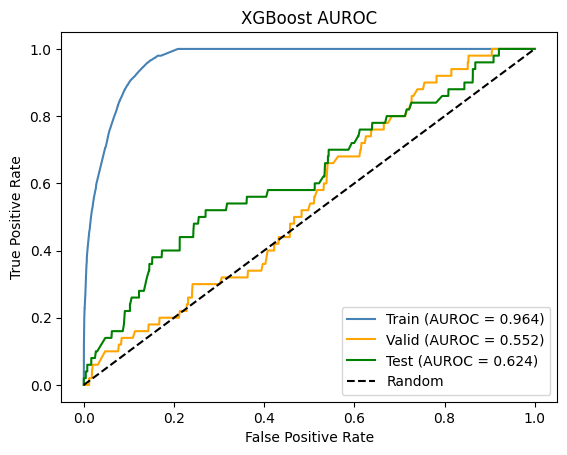

In [63]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

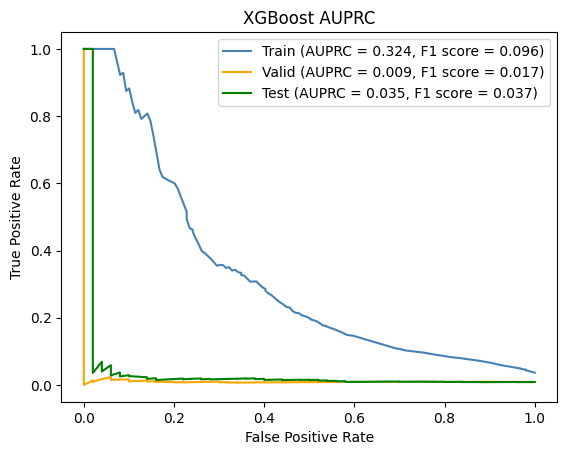

In [64]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

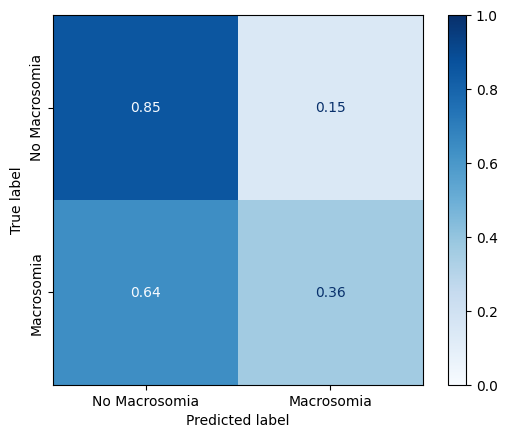

In [65]:
#plotting confusion matrix
predictions = selection_model.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=selection_model.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        selection_model,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

In [66]:
# #optimizating using Grid Search

# #ROUND 1

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.5, 1],
#     'reg_lambda': [0, 5, 10], 
#     'n_estimators': [50, 70, 90],
#     'min_child_weight': [5, 6, 7]
# }

In [72]:
# #ROUND 2

# param_grid = {
#     'max_depth': [1, 2, 3],
#     'learning_rate': [0.001, 0.005, 0.01],
#     'gamma': [0.5],
#     'reg_lambda': [0], 
#     'n_estimators': [30, 40, 50],
#     'min_child_weight': [3, 4, 5]
# }

In [77]:
#ROUND 3

param_grid = {
    'max_depth': [2],
    'learning_rate': [0.01],
    'gamma': [0.5],
    'reg_lambda': [0], 
    'n_estimators': [40],
    'min_child_weight': [1, 2, 3]
}

In [78]:
# #ROUND 4

# param_grid = {
#     'max_depth': [2],
#     'learning_rate': [0.3],
#     'gamma': [0],
#     'reg_lambda': [5], 
#     'n_estimators': [20],
#     'min_child_weight': [0, 0.5, 1]
# }

In [79]:
#grid searching for best hyperparameters
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5,
                                scale_pos_weight = 126,
                                missing = 0),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs = 10,
    cv = 5
)

In [80]:
#printing optimal parameters to readjust for actual training
optimal_params.fit(select_X_train, 
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(select_X_valid, y_valid)],
                  verbose=False)
print(optimal_params.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 40, 'reg_lambda': 0}


In [81]:
#fitting model to tuned hyperparameters
selection_model = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42,
                            gamma=0.5,
                            learning_rate=0.01,
                            max_depth=2,
                            min_child_weight = 1,
                            n_estimators = 40,
                            reg_lambda=0,
                            scale_pos_weight=126, #sum(negative instances) / sum(positive instances)d
                            subsample=0.9,
                            colsample_bytree=0.5,
                            missing = 0)

selection_model.fit(select_X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='auc',
           eval_set=[(select_X_train, y_train), (select_X_valid, y_valid), (select_X_test, y_test)])

[0]	validation_0-auc:0.72133	validation_1-auc:0.71945	validation_2-auc:0.65902
[1]	validation_0-auc:0.73378	validation_1-auc:0.72803	validation_2-auc:0.67401
[2]	validation_0-auc:0.74112	validation_1-auc:0.73429	validation_2-auc:0.68051
[3]	validation_0-auc:0.73470	validation_1-auc:0.72467	validation_2-auc:0.69105
[4]	validation_0-auc:0.74319	validation_1-auc:0.73599	validation_2-auc:0.68475
[5]	validation_0-auc:0.75702	validation_1-auc:0.75917	validation_2-auc:0.70291
[6]	validation_0-auc:0.75740	validation_1-auc:0.75882	validation_2-auc:0.69218
[7]	validation_0-auc:0.75947	validation_1-auc:0.75624	validation_2-auc:0.69462
[8]	validation_0-auc:0.75350	validation_1-auc:0.74966	validation_2-auc:0.69877
[9]	validation_0-auc:0.75096	validation_1-auc:0.74026	validation_2-auc:0.68703
[10]	validation_0-auc:0.74900	validation_1-auc:0.73720	validation_2-auc:0.68599
[11]	validation_0-auc:0.74694	validation_1-auc:0.73435	validation_2-auc:0.68761
[12]	validation_0-auc:0.75009	validation_1-auc:0.7

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=0, monotone_constraints='()', n_estimators=40, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=0, ...)

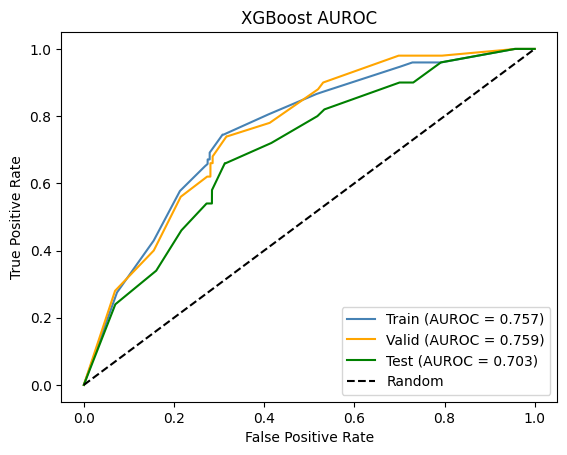

In [82]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

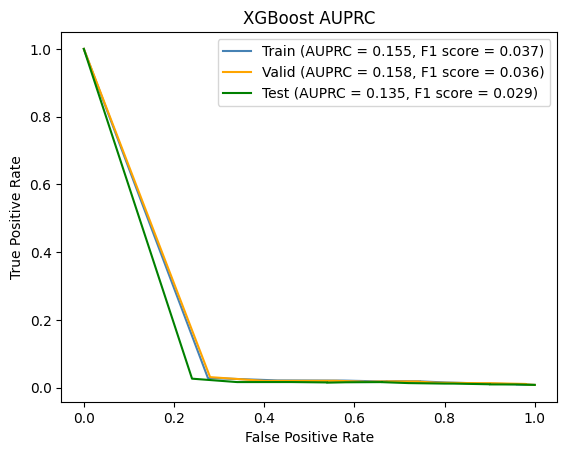

In [83]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

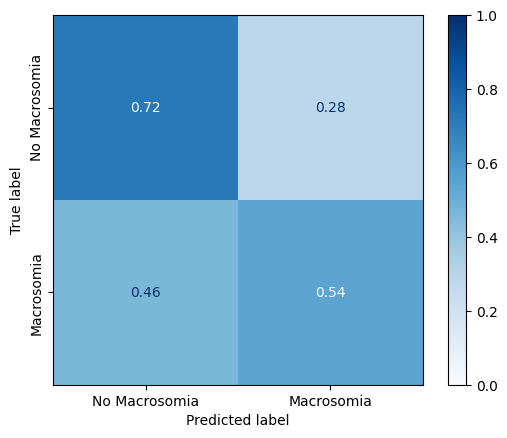

In [84]:
#plotting confusion matrix
predictions = selection_model.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=selection_model.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        selection_model,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

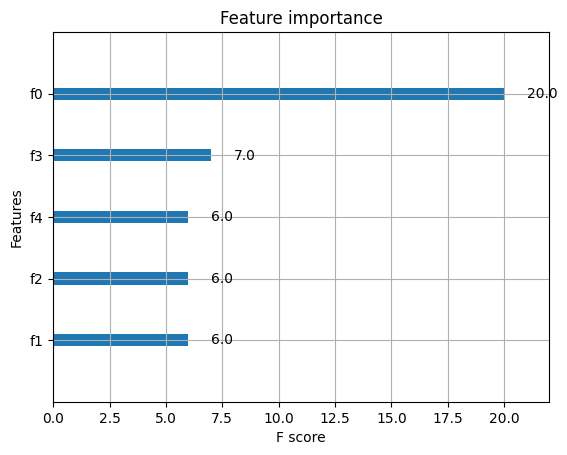

In [85]:
#plotting overall feature importance
plot_importance(selection_model)
plt.show()

In [86]:
#plotting individual feature importance
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.force(shap_values[1])

## Scenario 16:

### Imputation method: XGB Missing parameter (XGB MP)
### Class imbalance: Yes (CI)
### Feature selection: Yes (FS)
### Optimization: Bayesian (Bay.)

In [ ]:
#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(select_X_train, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators, learning_rate, reg_lambda, min_child_weight):
    params = {'max_depth': int(max_depth),
              'learning_rate':learning_rate,
              'gamma': gamma,
              'reg_lambda': reg_lambda,
              'n_estimators': int(n_estimators),
              'min_child_weight': min_child_weight,
              'subsample': 0.9,
              'eta': 0.1,
              
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'learning_rate': (0, 1),
                                            'gamma': (0, 5),
                                            'reg_lambda': (3, 20), 
                                            'n_estimators': (50, 350),
                                            'min_child_weight': (1, 10)
                                            }, random_state = 42)

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
[09:16:34] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:16:34] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:16:34] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } mig

|  5        | -0.08746  |  2.28     |  0.7852   |  4.398    |  5.628    |  227.7    |  3.79     |
[09:17:05] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:17:05] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:17:05] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

|  10       | -0.087    |  0.621    |  0.7127   |  8.185    |  2.408    |  240.1    |  18.04    |
[09:17:36] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:17:36] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:17:36] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

In [ ]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
bay_classifier = XGBClassifier(**params).fit(select_X_train, y_train)

#predicting for training set
train_p2 = bay_classifier.predict(select_X_valid)

#Looking at the classification report
print(classification_report(train_p2, y_valid))

In [ ]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = bay_classifier.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

In [ ]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()
y_pred = bay_classifier.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

In [ ]:
#plotting confusion matrix
predictions = bay_classifier.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=bay_classifier.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        bay_classifier,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

In [ ]:
#plotting tree
bst = bay_classifier.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(bay_classifier, num_trees=1, 
                size='10,10',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

In [ ]:
#plotting overall feature importance
plot_importance(bay_classifier)
plt.show()

In [ ]:
#plotting individual feature importance
explainer = shap.Explainer(bay_classifier)
shap_values = explainer(select_X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])